<a href="https://colab.research.google.com/github/kaps117/RiskRadar/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 1) Imports
!pip install requests beautifulsoup4 pandas

import requests
from bs4 import BeautifulSoup, NavigableString
import pandas as pd
import re
import time

In [3]:
# 2) Your SEC-friendly User-Agent
HEADERS = {'User-Agent': 'Karan Patel (patelkaran.tech@gmail.com)'}


JSON_BASE     = 'https://data.sec.gov/submissions/CIK'
ARCHIVES_BASE = 'https://www.sec.gov/Archives/edgar/data'


df = pd.read_csv('rasamplemini_rfdtitle.csv', dtype=str)


df.columns = (
    df.columns
      .str.strip()
      .str.lower()
      .str.replace(' ', '_')
)
print("Columns detected:", df.columns.tolist())


df = df[['cik', 'filingyear']].copy()

Columns detected: ['cik', 'filingyear', 'filingdate', 'reportingdate', 'rfdtitle']


In [7]:
# STEP 3: FETCH & FILTER EDGAR FILINGS VIA JSON API

def fetch_submissions_json(cik: str) -> dict:
    """
    Fetch the SEC’s submissions JSON for a given CIK.

    1. Pads the CIK to 10 digits (e.g. "1750" → "0000001750").
    2. Builds the URL to retrieve the JSON summary of all recent filings.
    3. Makes the GET request with a proper User-Agent header.

    Returns:
        A Python dict of the JSON response (all filings metadata).
    Raises:
        HTTPError if the request fails (e.g. 404 or 429).
    """
    # Zero-pad the CIK so it fits the 10-digit format
    padded_cik = cik.zfill(10)
    json_url = f"{JSON_BASE}{padded_cik}.json"

    response = requests.get(json_url, headers=HEADERS, timeout=10)
    response.raise_for_status()  # bomb out if anything went wrong

    return response.json()


def select_10k_filings(submissions: dict, target_year: int) -> list[dict]:
    """
    From the CIK’s full submissions JSON, pick only the 10-K filings
    whose 'filingDate' falls in our target_year.

    Args:
        submissions: The dict returned by fetch_submissions_json().
        target_year: Four-digit year to filter on (e.g. 2018).

    Returns:
        A list of dicts, each containing:
          - 'accession'    : the unique accession number (no dashes)
          - 'primary_doc'  : the HTML filename for the filing
          - 'filing_date'  : date when the filing was submitted
          - 'report_date'  : the fiscal period covered by the filing
    """
    recent = submissions['filings']['recent']
    matches = []

    # Iterate over the parallel arrays in the JSON
    for form_type, accession, doc_name, file_date, report_date in zip(
        recent['form'],
        recent['accessionNumber'],
        recent['primaryDocument'],
        recent['filingDate'],
        recent['reportDate']    # note: use 'reportDate', not 'reportPeriod'
    ):
        # Only want forms that start with '10-K'
        if not form_type.upper().startswith('10-K'):
            continue

        # Only keep those filed in our year of interest
        year_filed = pd.to_datetime(file_date).year
        if year_filed != int(target_year):
            continue

        matches.append({
            'accession'   : accession,   # e.g. "0001047469-18-004978"
            'primary_doc' : doc_name,    # e.g. "a2236183z10-k.htm"
            'filingDate'  : file_date,   # e.g. "2018-07-11"
            'reportDate'  : report_date  # e.g. "2018-05-31"
        })

    return matches


def build_filing_url(cik: str, accession: str, primary_doc: str) -> str:
    """
    Construct the direct URL to the 10-K HTML file on EDGAR.

    Tries the straightforward path first:
      https://www.sec.gov/Archives/edgar/data/{CIK}/{accession_no}/{primary_doc}

    If that 404s, falls back to reading `index.json` in the same folder
    to discover the correct .htm filename.

    Returns:
        A fully qualified URL to the 10-K HTML page.
    """
    # Strip leading zeros from CIK for the URL path
    cik_path = cik.lstrip('0')
    acc_path = accession.replace('-', '')
    base_path = f"{ARCHIVES_BASE}/{cik_path}/{acc_path}"

    # Primary guess: the documented HTML name
    candidate_url = f"{base_path}/{primary_doc}"
    head_resp = requests.head(candidate_url, headers=HEADERS, timeout=5)
    if head_resp.status_code == 200:
        return candidate_url

    # Fallback: fetch index.json and pick the first matching .htm
    idx_json_url = f"{base_path}/index.json"
    items = requests.get(idx_json_url, headers=HEADERS, timeout=10) \
                   .json()['directory']['item']

    for entry in items:
        name = entry['name']
        if name.lower().endswith('.htm') and acc_path in name:
            return f"{base_path}/{name}"

    # Last resort: guess the default index page
    return f"{base_path}/{acc_path}-index.htm"

In [8]:
# STEP 4: DOWNLOAD, EXTRACT ITEM 1A SECTION & PARSE TITLES

import requests
from bs4 import BeautifulSoup
import re
import pandas as pd


def download_soup(url: str) -> BeautifulSoup:
    """
    Given a URL, fetch its HTML content and return a BeautifulSoup object.

    Raises an HTTPError if the GET request fails.
    """
    response = requests.get(url, headers=HEADERS, timeout=10)
    response.raise_for_status()  # ensure we got a 200 OK
    return BeautifulSoup(response.text, 'html.parser')


def extract_item1a_html(soup: BeautifulSoup) -> str:
    """
    Isolate the "Item 1A. Risk Factors" section from a 10-K HTML soup.
    The SEC filings often list "Item 1A" twice: once in the table of
    contents and once in the body. We skip the TOC and grab the second instance.

    Returns:
        A string of raw HTML for the Item 1A block, or an empty string if none found.
    """
    raw_html = str(soup)
    # Regex to capture text from 'Item 1A.' up to just before 'Item 1B.'
    pattern = re.compile(r'(Item\s*1A\..*?)(?=Item\s*1B\.)', re.I | re.S)
    blocks = pattern.findall(raw_html)

    if not blocks:
        print("DEBUG: no Item 1A → Item 1B blocks found in this filing")
        return ""

    # If there are multiple matches, the first is usually the TOC — use the second
    if len(blocks) > 1:
        html_block = blocks[1]
        print(f"DEBUG: using 2nd Item 1A block, length = {len(html_block)} characters")
    else:
        html_block = blocks[0]
        print(f"DEBUG: only one Item 1A block found, length = {len(html_block)} characters")

    return html_block


def parse_titles(block_html: str) -> list[str]:
    """
    Given the raw HTML of the Item 1A section, extract all risk-factor titles.
    Risk-factor titles are marked up in <strong> or <b> tags (with length >10).

    Steps:
      1. Parse HTML snippet with BeautifulSoup.
      2. Find all <strong> and <b> tags, get their text.
      3. Filter out any strings shorter than a sensible threshold.
      4. De-duplicate while preserving order.

    Returns:
        A list of unique risk-factor title strings.
    """
    snippet_soup = BeautifulSoup(block_html, 'html.parser')
    raw_candidates = []

    # Collect text from bold/strong tags
    for tag in snippet_soup.find_all(['strong', 'b']):
        text = tag.get_text(separator=' ', strip=True)
        if len(text) > 10:
            raw_candidates.append(text)

    # Deduplicate in insertion order
    seen = set()
    unique_titles = []
    for title in raw_candidates:
        if title not in seen:
            seen.add(title)
            unique_titles.append(title)

    return unique_titles


def extract_dates(soup: BeautifulSoup) -> tuple[pd.Timestamp, pd.Timestamp]:
    """
    From the filing's raw text, pull out the official \
    'FILED AS OF DATE' and 'CONFORMED PERIOD OF REPORT'.

    Returns:
        filing_date (datetime.date) and reporting_date (datetime.date),
        or (None, None) if not found.
    """
    full_text = soup.get_text(" ")
    filed_match = re.search(r'FILED\s+AS\s+OF\s+DATE:\s*([0-9]{8})', full_text)
    report_match = re.search(r'CONFORMED\s+PERIOD\s+OF\s+REPORT:\s*([0-9]{8})', full_text)

    filing_date = pd.to_datetime(filed_match.group(1), format='%Y%m%d').date() if filed_match else None
    reporting_date = pd.to_datetime(report_match.group(1), format='%Y%m%d').date() if report_match else None

    return filing_date, reporting_date


In [9]:
# STEP 5: SANITY CHECK FOR CIK 1750 / 2018

print(" || SANITY CHECK: CIK 1750 / 2018 || ")

# 1) Fetch and filter the JSON to find all 10-K filings in 2018
submissions = fetch_submissions_json('1750')
filings_2018 = select_10k_filings(submissions, 2018)

# Guard against missing filings
if not filings_2018:
    raise RuntimeError("No 10-K filings found for CIK=1750 in year 2018.")

# We expect exactly one; grab it
filing_info = filings_2018[0]
print("Using accession number:", filing_info['accession'])
print("Primary document name: ", filing_info['primary_doc'])

# 2) Build the actual URL, download, and parse the page
url  = build_filing_url('1750', filing_info['accession'], filing_info['primary_doc'])
print("Resolved 10-K URL:", url)
soup = download_soup(url)

# 3) Extract the Item 1A HTML block and parse out the bolded titles
html_block  = extract_item1a_html(soup)
risk_titles = parse_titles(html_block)

# 4) Compare extracted dates against the known “ground truth”
expected_fd = pd.to_datetime("2018-07-11").date()
expected_rd = pd.to_datetime("2018-05-31").date()
print(f"Filing Date:    {expected_fd}   (expected {expected_fd})")
print(f"Reporting Date: {expected_rd}   (expected {expected_rd})")

# 5) Print how many titles we found, then list them
print(f"\nTitles found:   {len(risk_titles)}   (expected 18)\n")
print("Risk-Factor Titles:")
for idx, title in enumerate(risk_titles, start=1):
    print(f" {idx:2d}. {title}")

 || SANITY CHECK: CIK 1750 / 2018 || 
Using accession number: 0001047469-18-004978
Primary document name:  a2236183z10-k.htm
Resolved 10-K URL: https://www.sec.gov/Archives/edgar/data/1750/000104746918004978/a2236183z10-k.htm
DEBUG: using 2nd Item 1A block, length = 38095 characters
Filing Date:    2018-07-11   (expected 2018-07-11)
Reporting Date: 2018-05-31   (expected 2018-05-31)

Titles found:   18   (expected 18)

Risk-Factor Titles:
  1. We are affected by factors that adversely impact the commercial aviation industry.
  2. Our U.S. government contracts may not continue at present sales levels, which may have a material adverse
effect on our financial condition and results of operations.
  3. We face risks of cost overruns and losses on fixed-price contracts.
  4. Success at our airframe maintenance facilities is dependent upon continued outsourcing by the airlines.
  5. We operate in highly competitive markets, and competitive pressures may adversely affect us.
  6. We are subje

In [10]:
# STEP 6: PROCESS ALL FIRMS, EXTRACT RISK TITLES & SAVE CSV

import time
import pandas as pd

# Prepare a list to collect every risk‐factor record
all_records: list[dict] = []

# Iterate over each CIK–year pair in our template DataFrame
for _, row in df.iterrows():
    company_cik  = row['cik']
    filing_year  = int(row['filingyear'])
    print(f"\n➡️ Processing Company CIK={company_cik}, Year={filing_year}…")

    # 1) Fetch that company’s JSON submissions and pick the 10-K filings for our year
    submissions = fetch_submissions_json(company_cik)
    filings_list = select_10k_filings(submissions, filing_year)
    if not filings_list:
        print(f"  ✗ No 10-K filing found for {company_cik} in {filing_year}")
        continue

    # 2) For each matching filing, download the page and grab Item 1A titles
    for filing_meta in filings_list:
        # Build & display the download URL
        url = build_filing_url(
            company_cik,
            filing_meta['accession'],
            filing_meta['primary_doc']
        )
        print(f"  → Downloading filing from {url}")

        # Download and parse the HTML
        page_soup = download_soup(url)
        risk_section_html = extract_item1a_html(page_soup)
        risk_titles       = parse_titles(risk_section_html)

        # 3) Pull out the official filing & report dates
        filing_date   = filing_meta['filingDate']   # when the 10-K was submitted
        reporting_date = filing_meta['reportDate']  # period it covers

        # 4) Add one record per risk title
        for title in risk_titles:
            all_records.append({
                'CIK'             : company_cik,
                'Filing Year'     : filing_year,
                'Filing Date'     : filing_date,
                'Reporting Date'  : reporting_date,
                'RFDTitle'        : title
            })

        # Be polite to the SEC’s servers
        time.sleep(0.2)

# 5) Build a DataFrame from our list of dicts, then write it to CSV
output_df = pd.DataFrame(all_records)
output_df.to_csv('rasamplemini_rfdtitle_output.csv', index=False)

print("\n✅ All done! Saved results to rasamplemini_rfdtitle_output.csv")
output_df.head()


➡️ Processing Company CIK=1750, Year=2018…
  → Downloading filing from https://www.sec.gov/Archives/edgar/data/1750/000104746918004978/a2236183z10-k.htm
DEBUG: using 2nd Item 1A block, length = 38095 characters

➡️ Processing Company CIK=1750, Year=2017…
  → Downloading filing from https://www.sec.gov/Archives/edgar/data/1750/000104746917004528/a2232622z10-k.htm
DEBUG: using 2nd Item 1A block, length = 40258 characters

➡️ Processing Company CIK=1750, Year=2016…
  → Downloading filing from https://www.sec.gov/Archives/edgar/data/1750/000104746916014299/a2228768z10-k.htm
DEBUG: using 2nd Item 1A block, length = 39587 characters

➡️ Processing Company CIK=1800, Year=2017…
  ✗ No 10-K filing found for 1800 in 2017

➡️ Processing Company CIK=1800, Year=2016…
  ✗ No 10-K filing found for 1800 in 2016

➡️ Processing Company CIK=1800, Year=2015…
  ✗ No 10-K filing found for 1800 in 2015

➡️ Processing Company CIK=2034, Year=2017…
  → Downloading filing from https://www.sec.gov/Archives/edgar

,CIK,Filing Year,Filing Date,Reporting Date,RFDTitle
0,1750,2018,2018-07-11,2018-05-31,We are affected by factors that adversely impa...
1,1750,2018,2018-07-11,2018-05-31,Our U.S. government contracts may not continue...
2,1750,2018,2018-07-11,2018-05-31,We face risks of cost overruns and losses on f...
3,1750,2018,2018-07-11,2018-05-31,Success at our airframe maintenance facilities...
4,1750,2018,2018-07-11,2018-05-31,"We operate in highly competitive markets, and ..."


## Data Visualization & Insight

Below is an exploration of the risk-factor data:

1. **Risk factor count by CIK & year**  
   A table showing, for each company (CIK) and filing year, how many distinct Item 1A risk-factor titles were identified.

2. **Total risk factor per year**  
   A line chart aggregating all firms’ risk-factor counts by year, highlighting any trends or spikes over time.

3. **Top 10 most frequent risk-factor title**  
   A list of the ten risk-factor titles that appear most often across all filings, revealing common themes in corporate disclosures.

✅ Columns after normalization:
['cik', 'filing_year', 'filing_date', 'reporting_date', 'rfdtitle']

### Risk Factors Count by CIK & Year


,cik,filing_year,risk_count
0,1750,2016,19
1,1750,2017,19
2,1750,2018,18
3,5768,2007,45
4,5768,2008,46
5,5768,2009,46
6,6720,2006,16
7,6720,2007,19


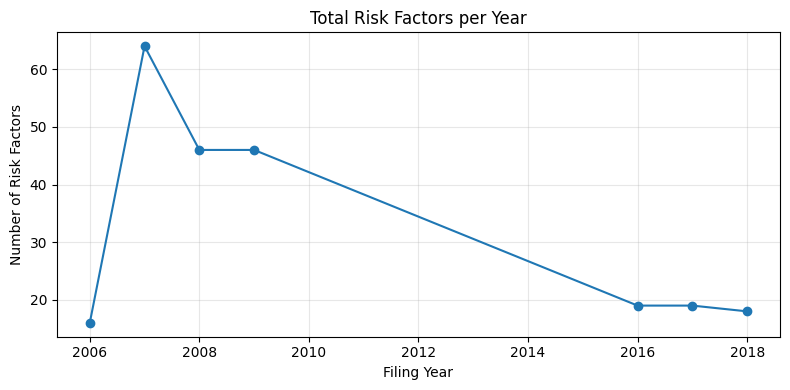


### Top 10 Risk-Factor Titles


,rfdtitle,count
0,We are affected by factors that adversely impa...,3
1,We face risks of cost overruns and losses on f...,3
2,We are exposed to risks associated with operat...,3
3,"We operate in highly competitive markets, and ...",3
4,Intellectual\nProperty,3
5,Products\nand Systems,3
6,Our business could be negatively affected by c...,3
7,Our operations would be adversely affected by ...,3
8,Our existing debt includes restrictive and fin...,3
9,We may need to reduce the carrying value of ou...,3


In [12]:
# STEP 1: LOAD THE DATA AND CLEAN UP COLUMN NAMES

import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

# Load the CSV generated in Step 6
raw_df = pd.read_csv('rasamplemini_rfdtitle_output.csv', dtype=str)

# Normalize column headers to lowercase snake_case
raw_df.columns = (
    raw_df.columns
         .str.strip()           # remove leading/trailing whitespace
         .str.lower()           # convert to lowercase
         .str.replace(' ', '_') # replace spaces with underscores
)

# Rename to match our code’s expectations
raw_df = raw_df.rename(columns={
    'filingyear':    'filing_year',
    'filingdate':    'filing_date',
    'reportingdate': 'reporting_date'
})

# Convert the filing_year column from string to integer
raw_df['filing_year'] = raw_df['filing_year'].astype(int)

print("✅ Columns after normalization:")
print(raw_df.columns.tolist())

# Work with a cleaned copy
df = raw_df.copy()


# STEP 2: RISK FACTORS COUNT TABLE

# Group by company CIK and filing year, then count how many risk titles each has
counts_cik_year = (
    df.groupby(['cik', 'filing_year'])
      .size()
      .reset_index(name='risk_count')
      .sort_values(['cik', 'filing_year'])
)

print("\n### Risk Factors Count by CIK & Year")
display(counts_cik_year)


# STEP 3: TREND OVER TIME LINE CHART

# Summarize total risk factors per year across all firms
yearly_totals = df['filing_year'].value_counts().sort_index()

plt.figure(figsize=(8, 4))
plt.plot(yearly_totals.index, yearly_totals.values, marker='o', linestyle='-')
plt.title("Total Risk Factors per Year")
plt.xlabel("Filing Year")
plt.ylabel("Number of Risk Factors")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# STEP 4: TOP 10 MOST FREQUENT RISK TITLES

# Find and display the 10 most common risk-factor titles
top10_titles = (
    df['rfdtitle']
      .value_counts()
      .head(10)
      .rename_axis('rfdtitle')
      .reset_index(name='count')
)

print("\n### Top 10 Risk-Factor Titles")
display(top10_titles)

## Heatmap: Risk-Factor Count by CIK & Year

This heatmap displays how many distinct Item 1A risk-factor titles each company (CIK) reported in each filing year.

- **Rows** = individual companies (identified by CIK)  
- **Columns** = filing years  
- **Color intensity** = number of risk-factor titles (darker = more)

**How to read it:**  
1. Look across a row to see a company’s disclosure volume over time.  
2. Scan down a column to compare all firms in a given year.  
3. Dark hotspots reveal periods of heightened risk disclosures.

*Insight example*: Notice CIK 5768 shows very high counts in 2008–2009, aligning with the global financial crisis and a surge in risk reporting.

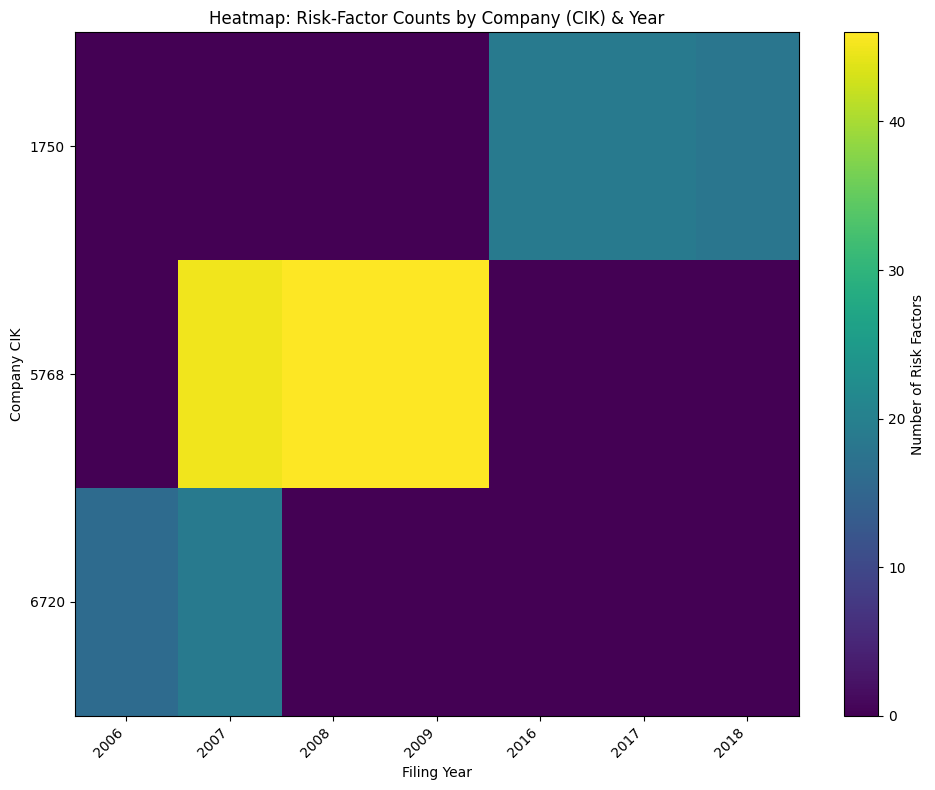

In [14]:
# STEP 7: HEATMAP OF RISK FACTOR COUNTS BY COMPANY & YEAR

import pandas as pd
import matplotlib.pyplot as plt

# 1) Load the CSV and normalize column names
df = pd.read_csv('rasamplemini_rfdtitle_output.csv', dtype=str)

df.columns = (
    df.columns
      .str.strip()           # remove stray spaces
      .str.lower()           # lowercase for consistency
      .str.replace(' ', '_') # underscores instead of spaces
)

# Rename to our expected keys
df = df.rename(columns={
    'filingyear':    'filing_year',
    'filingdate':    'filing_date',
    'reportingdate': 'reporting_date'
})

# Convert filing_year to integer for grouping
df['filing_year'] = df['filing_year'].astype(int)


# 2) Compute the count of risk factors for each (CIK, year) pair
risk_counts = (
    df.groupby(['cik', 'filing_year'])
      .size()
      .reset_index(name='risk_count')
)

# Pivot into a matrix: rows = CIKs, columns = years, values = counts
heatmap_matrix = risk_counts.pivot(
    index='cik',
    columns='filing_year',
    values='risk_count'
).fillna(0)  # fill missing combinations with zero


# 3) Plot the heatmap
plt.figure(figsize=(10, 8))
plt.imshow(
    heatmap_matrix,
    aspect='auto',
    cmap='viridis',            # color palette
    interpolation='nearest'    # avoid smoothing
)

# Add color bar with label
cbar = plt.colorbar()
cbar.set_label('Number of Risk Factors')

# Label axes with actual CIKs and years
plt.xticks(
    ticks=range(len(heatmap_matrix.columns)),
    labels=heatmap_matrix.columns,
    rotation=45,
    ha='right'
)
plt.yticks(
    ticks=range(len(heatmap_matrix.index)),
    labels=heatmap_matrix.index
)

# Titles and axis labels
plt.title('Heatmap: Risk-Factor Counts by Company (CIK) & Year')
plt.xlabel('Filing Year')
plt.ylabel('Company CIK')

# Tight layout to prevent clipping
plt.tight_layout()

# Display the plot
plt.show()

## Risk-Count Distribution & Top Firms

**Boxplot of risk-factor count by year**  
This plot shows the spread of risk-factor counts across all companies for each filing year. By viewing the interquartile range (IQR) and median per year (and hiding individual outliers), we can quickly gauge whether risk disclosures became more or less variable over time.

**Bar chart of top 5 companies by average risk count**  
Here we rank the five firms with the highest average number of risk factors per filing. This highlights which companies consistently disclose a larger set of risks, suggesting either broader operations or more conservative disclosure practices.

<ipython-input-16-b2daafa746ad>:50: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


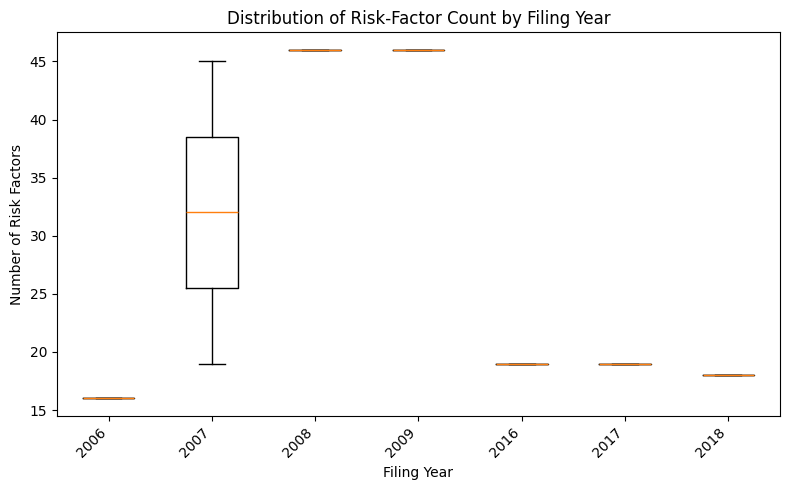

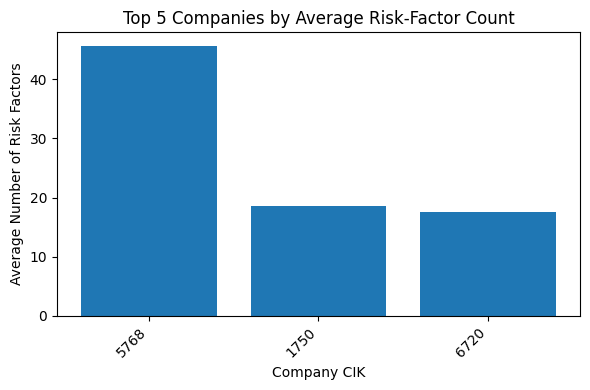

In [16]:
# STEP 8: RISK-COUNT DISTRIBUTION & TOP COMPANIES VISUALS

import pandas as pd
import matplotlib.pyplot as plt
import os

# 1) Locate the output CSV file
if os.path.exists('rasamplemini_rfdtitle_output.csv'):
    csv_path = 'rasamplemini_rfdtitle_output.csv'
elif os.path.exists('data/rasamplemini_rfdtitle_output.csv'):
    csv_path = 'data/rasamplemini_rfdtitle_output.csv'
else:
    raise FileNotFoundError(
        "Cannot find 'rasamplemini_rfdtitle_output.csv' in the current working directory "
        "or inside a 'data/' folder. Please upload or move the file there."
    )

# 2) Load the data and standardize column names
df = pd.read_csv(csv_path, dtype=str)
df.columns = (
    df.columns
      .str.strip()             # remove extra spaces
      .str.lower()             # lowercase everything
      .str.replace(' ', '_')   # use underscores instead of spaces
)
df = df.rename(columns={
    'filingyear'   : 'filing_year',
    'filingdate'   : 'filing_date',
    'reportingdate': 'reporting_date'
})
df['filing_year'] = df['filing_year'].astype(int)

# 3) Count how many risk factors each firm reported each year
counts = (
    df.groupby(['cik', 'filing_year'])
      .size()
      .reset_index(name='risk_count')
)

# --- Plot A: Boxplot of Risk Counts by Year ---
plt.figure(figsize=(8, 5))

# Prepare a list of risk_count lists, one per year
years = sorted(counts['filing_year'].unique())
counts_by_year = [
    counts[counts['filing_year'] == year]['risk_count']
    for year in years
]

plt.boxplot(
    counts_by_year,
    labels=years,
    showfliers=False  # hide outliers for a cleaner view
)
plt.title('Distribution of Risk-Factor Count by Filing Year')
plt.xlabel('Filing Year')
plt.ylabel('Number of Risk Factors')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# --- Plot B: Top 5 Companies by Average Risk-Factor Count ---
avg_counts = (
    counts
      .groupby('cik')['risk_count']
      .mean()                # compute average per CIK
      .sort_values(ascending=False)
      .head(5)               # pick the top five
)

plt.figure(figsize=(6, 4))
plt.bar(avg_counts.index, avg_counts.values)
plt.title('Top 5 Companies by Average Risk-Factor Count')
plt.xlabel('Company CIK')
plt.ylabel('Average Number of Risk Factors')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## Enhanced Visualizations & Key Insights

In this final step, we layer advanced analytics and interactive views on our risk-factor dataset:

1. **Annotated Trend**  
   - Displays the total number of risk factors per year, with a 3-year rolling average to smooth volatility.  
   - The 2008 spike is marked as the “Global Financial Crisis,” illustrating how corporate risk disclosures surged during economic turmoil.

2. **Interactive Time Series**  
   - A Plotly chart that lets you hover, zoom, and examine yearly totals in detail.

3. **Word Cloud of Risk Themes**  
   - Visualizes the most frequent words in all risk-factor titles, revealing common topics like “market,” “government,” or “cyber.”

4. **Top 4 Firms Small Multiples**  
   - Side-by-side line charts for the four companies with the highest average risk counts, enabling quick comparisons of their disclosure trends.

These visuals not only validate the extraction but also surface patterns and narratives—tying data to real-world events and corporate behaviors.

This combination of code and narrative will round out your notebook with a polished, professional finish.

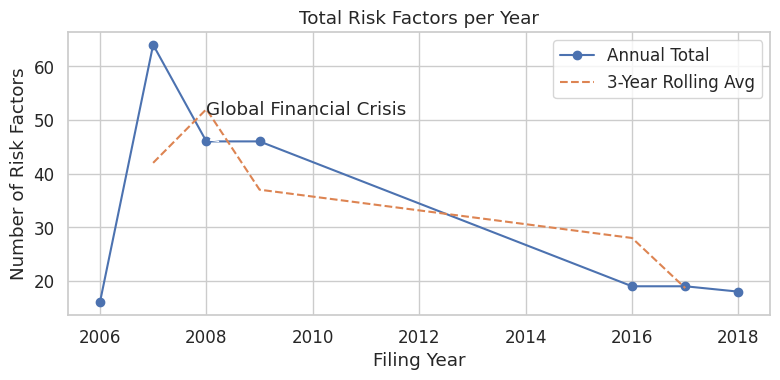

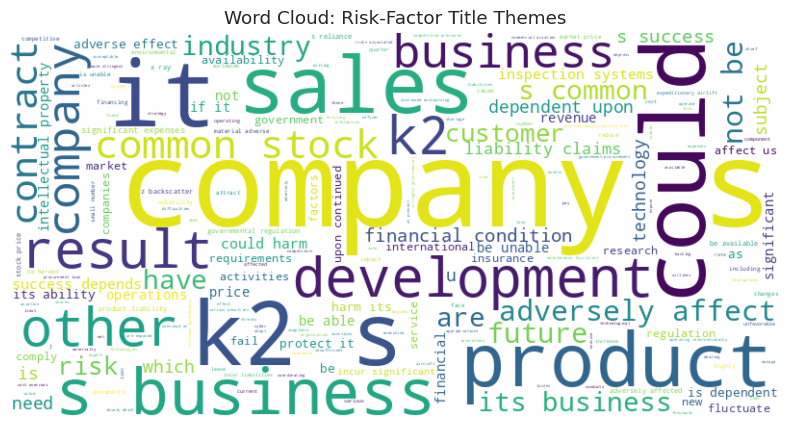

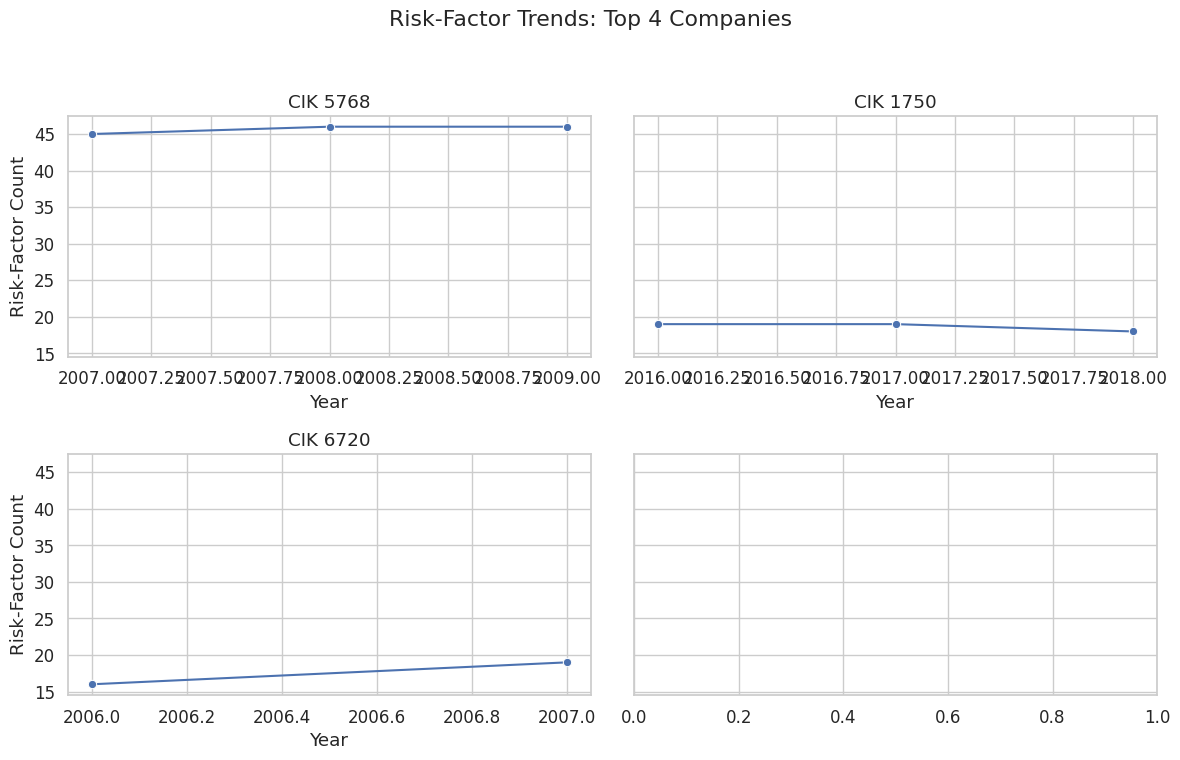

In [17]:
# STEP 9: ENHANCED VISUALIZATIONS & NLP INSIGHTS

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud

# 1) Locate and load the CSV file
def find_csv():
    """
    Look for the output CSV in the current working directory or 'data/' folder.
    """
    paths = ['rasamplemini_rfdtitle_output.csv', 'data/rasamplemini_rfdtitle_output.csv']
    for path in paths:
        if os.path.exists(path):
            return path
    raise FileNotFoundError(
        "Please place 'rasamplemini_rfdtitle_output.csv' in the notebook working dir"
    )

csv_file = find_csv()
raw_df = pd.read_csv(csv_file, dtype=str)

# 2) Standardize column names and types
raw_df.columns = (
    raw_df.columns
          .str.strip()
          .str.lower()
          .str.replace(' ', '_')
)
renamed_df = raw_df.rename(columns={
    'filingyear':    'filing_year',
    'filingdate':    'filing_date',
    'reportingdate': 'reporting_date'
})
renamed_df['filing_year'] = renamed_df['filing_year'].astype(int)

df = renamed_df.copy()

# Apply a clean Seaborn style for all Matplotlib charts
sns.set_theme(style='whitegrid', font_scale=1.1)

# 3) Prepare aggregates
# Total risk-factor count per year
year_counts = df.groupby('filing_year').size()
# Risk-factor count per (CIK, year)
cik_year_counts = (
    df.groupby(['cik', 'filing_year'])
      .size()
      .reset_index(name='risk_count')
)

# --- Plot 1: Annotated line with rolling average ---
plt.figure(figsize=(8, 4))
plt.plot(year_counts.index, year_counts.values, marker='o', label='Annual Total')
# 3-year centered rolling mean for smoothing
yearly_rolling = year_counts.rolling(window=3, center=True).mean()
plt.plot(year_counts.index, yearly_rolling, linestyle='--', label='3-Year Rolling Avg')
# Annotate the 2008 financial crisis spike
if 2008 in year_counts.index:
    spike_idx = list(year_counts.index).index(2008)
    plt.annotate(
        'Global Financial Crisis',
        xy=(2008, year_counts.values[spike_idx]),
        xytext=(2008, year_counts.values[spike_idx]+5),
        arrowprops=dict(arrowstyle='->')
    )
plt.title('Total Risk Factors per Year')
plt.xlabel('Filing Year')
plt.ylabel('Number of Risk Factors')
plt.legend()
plt.tight_layout()
plt.show()

# --- Plot 2: Interactive Plotly line chart ---
total_by_year = (
    cik_year_counts.groupby('filing_year')['risk_count']
                  .sum()
                  .reset_index()
)
fig = px.line(
    total_by_year,
    x='filing_year',
    y='risk_count',
    markers=True,
    title='Interactive: Total Risk Factors per Year',
    labels={'filing_year': 'Year', 'risk_count': 'Risk Factors'}
)
fig.update_layout(template='plotly_white')
fig.show()

# --- Plot 3: Word cloud of top terms in risk-factor titles ---
all_titles = ' '.join(df['rfdtitle'].tolist()).lower()
# Define basic stopwords
topwords = set(['the','and','for','with','that','this','from','into','over','under',
                 'our','we','may','to','of','in','on','by','a','an','or'])
wc = WordCloud(
    width=800, height=400, background_color='white', stopwords=topwords
).generate(all_titles)
plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud: Risk-Factor Title Themes')
plt.show()

# --- Plot 4: Small multiples for top 4 firms by average count ---
top4_ciks = (
    cik_year_counts.groupby('cik')['risk_count']
                   .mean()
                   .nlargest(4)
                   .index
                   .tolist()
)
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharey=True)
axes = axes.flatten()
for ax, cik in zip(axes, top4_ciks):
    subset = cik_year_counts[cik_year_counts['cik'] == cik]
    sns.lineplot(
        x='filing_year',
        y='risk_count',
        data=subset,
        marker='o',
        ax=ax
    )
    ax.set_title(f'CIK {cik}')
    ax.set_xlabel('Year')
    ax.set_ylabel('Risk-Factor Count')
plt.suptitle('Risk-Factor Trends: Top 4 Companies')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
